In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import tensorflow as tf

from datetime import datetime

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
from IPython.display import Image

### build a simple NN for  MNIST dataset

load the mnist dataset

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [5]:
n_inputs = 28*28  # MNIST
n_hidden1 = 30
n_outputs = 10 # digits 0-9, 10 classes


reset_graph()
# if batch size is 64, then x is 64 x 784
# if batch size is 128, then x is 128 x 784
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="input")   # "None" is for batch size
y = tf.placeholder(tf.int32, shape=(None), name="y")

x_image = tf.reshape(X,[-1,28,28,1])  # reshpae for 2d conv

In [6]:
learning_rate = 0.01

with tf.name_scope("dnn"):
#     conv1 = tf.layers.conv2d(x_image,  4, kernel_size=3, padding='same', name="conv1", use_bias=False)
#     conv2 = tf.layers.conv2d(conv1,  4, kernel_size=3, padding='same', name="conv2", use_bias=False)
    
    conv1 = tf.layers.conv2d(x_image,  4, kernel_size=3, padding='same', name="conv1", use_bias=True)
    conv2 = tf.layers.conv2d(conv1,  4, kernel_size=3, padding='same', name="conv2", use_bias=True)
    
    hidden1 = tf.layers.dense(tf.contrib.layers.flatten(conv2),   n_hidden1, name="hidden1", activation=tf.nn.relu)
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")
    y_proba = tf.nn.softmax(logits)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)   

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
    
for v in tf.trainable_variables():
    if "conv" in v.name and "kernel" in v.name:
        # 3 x 3 x 1 x 4
        img_kernels = v
        
        #print(type(img_kernels))
        #print(img_kernels.shape)
        
        # 4 x 3 x 3 x 1 (one kernel per activation map and channel)
        img_kernels = tf.transpose(img_kernels, perm=[3, 0, 1, 2])
        # 4 x 3 x 3 x 1 (one kernel per activation map)
        img_kernels = tf.reduce_mean(img_kernels, axis=3, keep_dims=True)
        
        v_name = v.name[:-2]
        #print(v_name)
        
        tf.summary.image(v_name, img_kernels, max_outputs=4)

    




summary = tf.summary.merge_all()


if summary == None:
    raise Exception("No summaries")


In [7]:
#tf.trainable_variables()

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [9]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [10]:
n_epochs = 8
batch_size = 50

with tf.Session() as sess:
    
    now = datetime.now()
    curTime = str(now.year) + '-' + str(now.month) + '-' + str(now.day) +\
            '_' + str(now.hour) + '-' + str(now.minute)

    logFile = './log-testFilter/' + curTime

    print(logFile)
    
    summary_writer = tf.summary.FileWriter(logFile, sess.graph)
    
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            training_v = sess.run([training_op], feed_dict={X: X_batch, y: y_batch})
            #print(loss_v)
            
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

        if epoch % 2 == 0:
            # write summary
            summary_str = sess.run(summary, feed_dict={X: X_valid, y: y_valid})
            summary_writer.add_summary(summary_str, epoch)
            summary_writer.flush()
        
        
        
    save_path = saver.save(sess, "./model_testFilter.ckpt")

./log-testFilter/2018-6-26_13-20
0 Batch accuracy: 0.98 Validation accuracy: 0.9356
1 Batch accuracy: 0.96 Validation accuracy: 0.9488
2 Batch accuracy: 0.96 Validation accuracy: 0.9546
3 Batch accuracy: 0.92 Validation accuracy: 0.9568
4 Batch accuracy: 0.98 Validation accuracy: 0.9584
5 Batch accuracy: 0.98 Validation accuracy: 0.9608
6 Batch accuracy: 1.0 Validation accuracy: 0.9634
7 Batch accuracy: 0.98 Validation accuracy: 0.9662


### visualize filters

In [11]:
# Open the terminal and run the Tensorboard command with you log file location.
# tensorboard --logdir=./log-testFilter/xxxxx

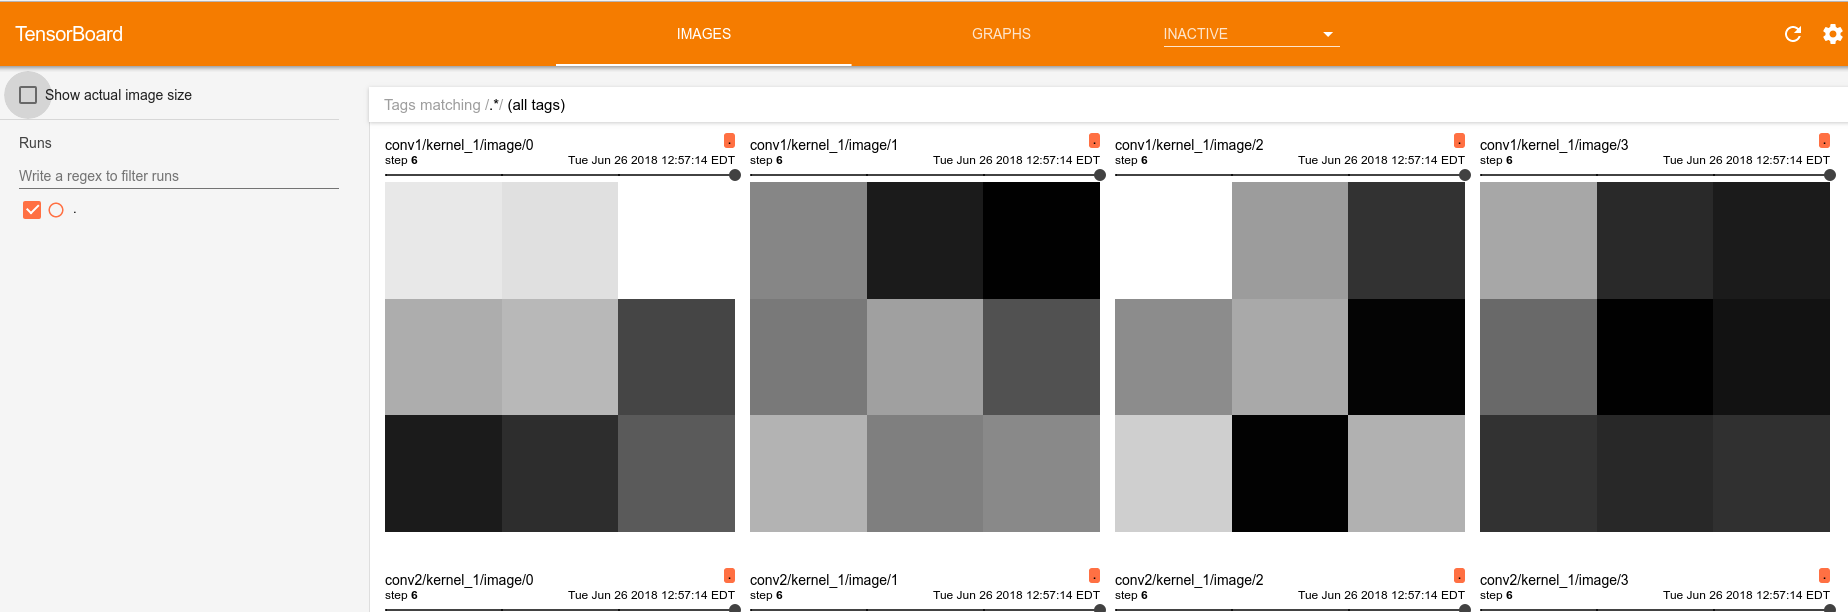

In [12]:
Image(filename='figs/tensorboard_kernel_img.png', width=500, height=500)

Reference:

* https://gist.github.com/kukuruza/03731dc494603ceab0c5 

* https://gitup.uni-potsdam.de/sadler/intro-deep-learning/blob/0e79b471c4f1581a4332f86ae75bbeb402fa7d1e/python/main/tf/mnist/LeNet.py